## Importing needed liberaries

In [1]:
import kagglehub
import os
import shutil
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

## Functions

In [2]:
def organize_dataset(dataset_path):

    base_dir = os.path.join(dataset_path, "organized_data")
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    for folder in [train_dir, val_dir, test_dir]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    training_path = os.path.join(dataset_path, "Training")
    testing_path = os.path.join(dataset_path, "Testing")

    if os.path.exists(training_path) and os.path.exists(testing_path):
        class_labels = os.listdir(training_path)
        print("Class labels found in Training directory:", class_labels)

        for label in class_labels:
            source_dir = os.path.join(training_path, label)
            if not os.path.exists(source_dir):
                print(f"Warning: {label} folder not found in Training directory.")
                continue

            images = os.listdir(source_dir)
            total_images = len(images)
            train_split = int(0.7 * total_images)
            val_split = int(0.85 * total_images)

            for i, image in enumerate(images):
                source_image = os.path.join(source_dir, image)
                if i < train_split:
                    dest_dir = os.path.join(train_dir, label)
                elif i < val_split:
                    dest_dir = os.path.join(val_dir, label)
                else:
                    dest_dir = os.path.join(test_dir, label)

                if not os.path.exists(dest_dir):
                    os.makedirs(dest_dir)

                shutil.copy(source_image, dest_dir)

        for label in class_labels:
            source_dir = os.path.join(testing_path, label)
            if not os.path.exists(source_dir):
                print(f"Warning: {label} folder not found in Testing directory.")
                continue

            dest_dir = os.path.join(test_dir, label)
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            for image in os.listdir(source_dir):
                shutil.copy(os.path.join(source_dir, image), dest_dir)

    else:
        class_labels = [
            label for label in os.listdir(dataset_path)
            if os.path.isdir(os.path.join(dataset_path, label)) and label != "organized_data"
        ]
        print("Class labels found:", class_labels)

        for label in class_labels:
            source_dir = os.path.join(dataset_path, label)
            images = os.listdir(source_dir)
            total_images = len(images)
            train_split = int(0.7 * total_images)
            val_split = int(0.85 * total_images)

            for i, image in enumerate(images):
                source_image = os.path.join(source_dir, image)
                if i < train_split:
                    dest_dir = os.path.join(train_dir, label)
                elif i < val_split:
                    dest_dir = os.path.join(val_dir, label)
                else:
                    dest_dir = os.path.join(test_dir, label)

                if not os.path.exists(dest_dir):
                    os.makedirs(dest_dir)

                shutil.copy(source_image, dest_dir)

    print("Dataset organized into train, val, and test directories.")
    return base_dir

In [3]:
def load_datasets(base_dir, img_size=(224, 224), batch_size=32):
    train_dataset = image_dataset_from_directory(
        os.path.join(base_dir, "train"),
        image_size=img_size,
        batch_size=batch_size
    )
    val_dataset = image_dataset_from_directory(
        os.path.join(base_dir, "val"),
        image_size=img_size,
        batch_size=batch_size
    )
    test_dataset = image_dataset_from_directory(
        os.path.join(base_dir, "test"),
        image_size=img_size,
        batch_size=batch_size
    )
    return train_dataset, val_dataset, test_dataset

In [4]:
def augment_dataset(dataset):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    return dataset.map(lambda x, y: (data_augmentation(x), y))

In [5]:
def prepare_datasets(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
def evaluate_metrics(test_ds, model):

    predictions = model.predict(test_ds)
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels = []
    for images, labels in test_ds:
        true_labels.extend(labels.numpy())

    cm = confusion_matrix(true_labels, predicted_labels)

    num_classes = cm.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        if TP + FP != 0:
            precision[i] = TP / (TP + FP)
        if TP + FN != 0:
            recall[i] = TP / (TP + FN)
        if precision[i] + recall[i] != 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    for i in range(num_classes):
        print(f"Class {i}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1 Score: {f1_score[i]:.4f}")
        print("-" * 20)

    Dataset_precision = np.mean(precision)
    Dataset_recall = np.mean(recall)
    Dataset_f1_score = np.mean(f1_score)


    print(f"averaged Precision: {Dataset_precision:.4f}")
    print(f"averaged Recall: {Dataset_recall:.4f}")
    print(f"averaged F1 Score: {Dataset_f1_score:.4f}")

    metrics_dict = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "Dataset_precision": Dataset_precision,
        "Dataset_recall": Dataset_recall,
        "Dataset_f1_score": Dataset_f1_score
    }
    return metrics_dict

In [7]:
def evaluate_confusion_matrix(test_ds, model):
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = []
    for _, labels in test_ds:
        y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred)

    print("Confusion Matrix:")
    print(cm)

    return cm

In [8]:
def build_model(input_shape=(224, 224, 3), num_classes=4, trainable_layers=20):

    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.01)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))

    model.summary()

    return model

## Dataset 1

In [9]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [10]:
print("Dataset files and folders:")
print(os.listdir(path))

Dataset files and folders:
['Testing', 'Training', 'organized_data']


In [11]:
organized_path = organize_dataset(path)

Class labels found in Training directory: ['meningioma', 'notumor', 'pituitary', 'glioma']
Dataset organized into train, val, and test directories.


Found 3996 files belonging to 4 classes.
Found 857 files belonging to 4 classes.
Found 2170 files belonging to 4 classes.


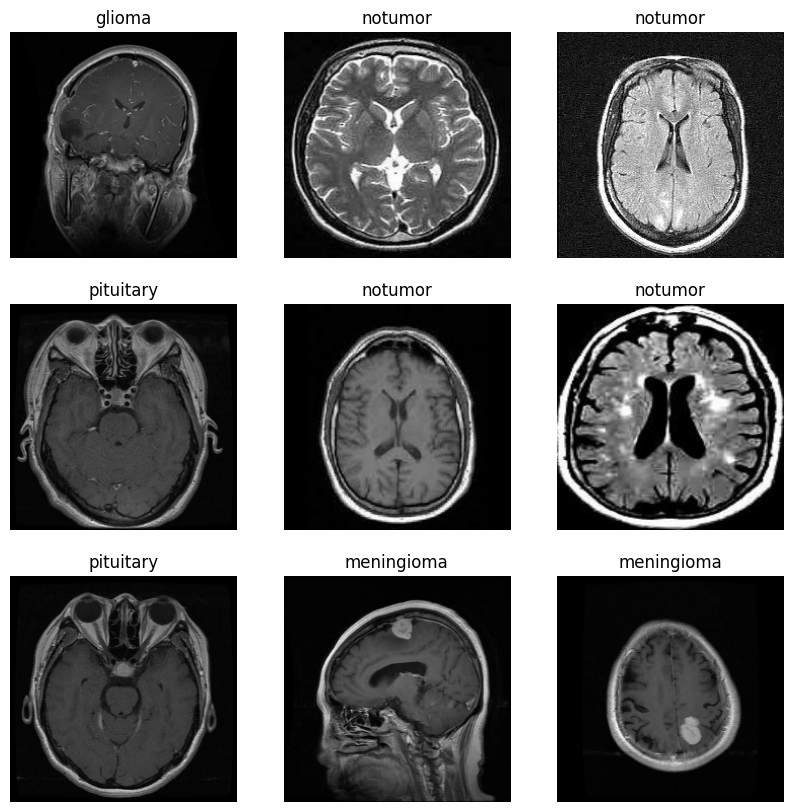

In [12]:
train_ds, val_ds, test_ds = load_datasets(organized_path)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

In [13]:
train_ds = augment_dataset(train_ds)
train_ds = prepare_datasets(train_ds)

val_ds = prepare_datasets(val_ds)
test_ds = prepare_datasets(test_ds)

In [14]:
Data1_model = build_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,567 (16.08 MB)

 Trainable params: 4,172,288 (15.92 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [15]:
Data1_model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = Data1_model.fit( train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 209s 993ms/step - accuracy: 0.7843 - loss: 2.5872 - val_accuracy: 0.2789 - val_loss: 4.8725
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 141ms/step - accuracy: 0.9397 - loss: 0.8341 - val_accuracy: 0.2765 - val_loss: 2.2284
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9684 - loss: 0.2871 - val_accuracy: 0.2859 - val_loss: 2.2298
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9751 - loss: 0.1539 - val_accuracy: 0.4411 - val_loss: 2.2148
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9764 - loss: 0.1226 - val_accuracy: 0.4457 - val_loss: 1.9859
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9877 - loss: 0.0912 - val_accuracy: 0.3221 - val_loss: 4.0739
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9888 - loss: 0.0813 - val_accuracy: 0.8051 - val_loss: 0.6998
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.9804 - loss: 

In [17]:
test_loss, test_accuracy = Data1_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.8325 - loss: 0.8154
Test Accuracy: 82.53%


In [18]:
metrics_dataset1 = evaluate_metrics(test_ds, Data1_model)

68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step
Class 0:
  Precision: 0.9710
  Recall: 0.6713
  F1 Score: 0.7938
--------------------
Class 1:
  Precision: 0.9899
  Recall: 0.5799
  F1 Score: 0.7313
--------------------
Class 2:
  Precision: 0.8032
  Recall: 1.0000
  F1 Score: 0.8909
--------------------
Class 3:
  Precision: 0.7131
  Recall: 0.9961
  F1 Score: 0.8312
--------------------
averaged Precision: 0.8693
averaged Recall: 0.8118
averaged F1 Score: 0.8118


In [19]:
cm_dataset1 = evaluate_confusion_matrix(test_ds, Data1_model)

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Confusion Matrix:
[[335   3 112  49]
 [ 10 294  44 159]
 [  0   0 645   0]
 [  0   0   2 517]]


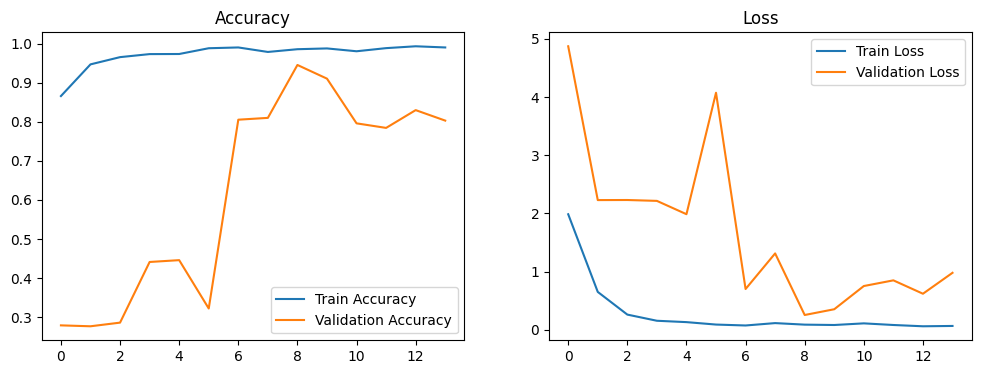

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

## Dataset 2

In [21]:
path2 = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path2)

Path to dataset files: /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


In [22]:
print("Dataset files and folders:")
print(os.listdir(path2))

Dataset files and folders:
['Testing', 'Training', 'organized_data']


In [23]:
organized_path2 = organize_dataset(path2)

Class labels found in Training directory: ['glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor']
Dataset organized into train, val, and test directories.


Found 2007 files belonging to 4 classes.
Found 430 files belonging to 4 classes.
Found 811 files belonging to 4 classes.


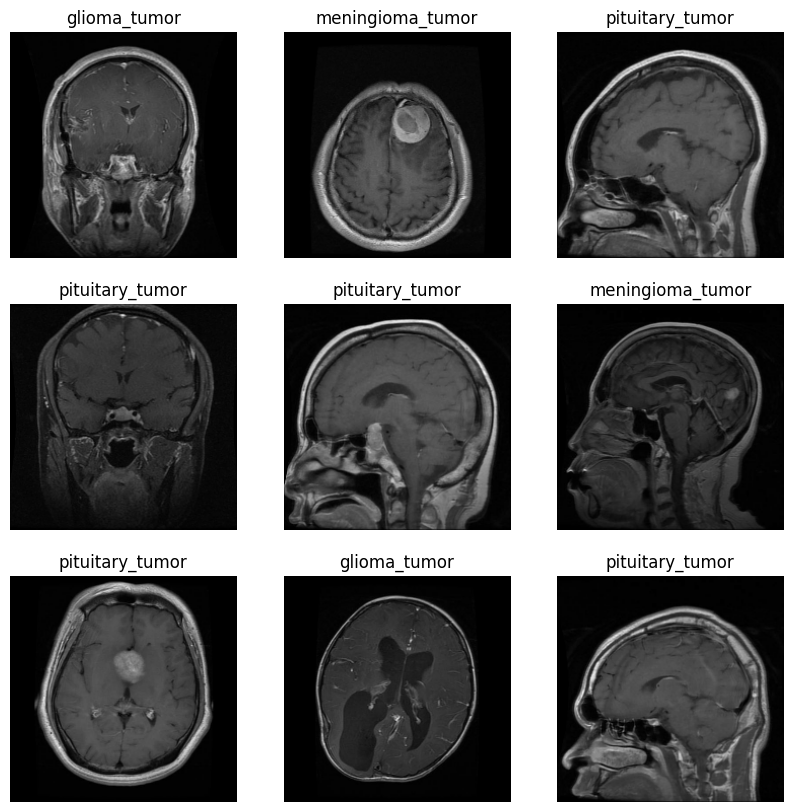

In [24]:
train_ds, val_ds, test_ds = load_datasets(organized_path2)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

In [25]:
train_ds = prepare_datasets(train_ds)
val_ds = prepare_datasets(val_ds)
test_ds = prepare_datasets(test_ds)

In [26]:
Data2_model = build_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,567 (16.08 MB)

 Trainable params: 4,172,288 (15.92 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [27]:
Data2_model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = Data2_model.fit( train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9967 - loss: 0.0338 - val_accuracy: 0.4302 - val_loss: 2.8443
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9954 - loss: 0.0633 - val_accuracy: 0.9186 - val_loss: 0.3065
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9931 - loss: 0.0489 - val_accuracy: 0.9372 - val_loss: 0.3469
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9922 - loss: 0.0540 - val_accuracy: 0.9535 - val_loss: 0.2643
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9914 - loss: 0.0650 - val_accuracy: 0.9349 - val_loss: 0.3237
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9955 - loss: 0.0421 - val_accuracy: 0.9395 - val_loss: 0.2296
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9936 - loss: 0.0397 - val_accuracy: 0.7953 - val_loss: 0.9290
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9965 - loss: 0.0429 - val_accuracy: 0

In [49]:
test_loss, test_accuracy = Data2_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8542 - loss: 0.9728
Test Accuracy: 84.83%


In [50]:
metrics_dataset2 = evaluate_metrics(test_ds, Data2_model)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Class 0:
  Precision: 0.9430
  Recall: 0.6652
  F1 Score: 0.7801
--------------------
Class 1:
  Precision: 0.7834
  Recall: 0.9079
  F1 Score: 0.8411
--------------------
Class 2:
  Precision: 0.7526
  Recall: 0.9799
  F1 Score: 0.8513
--------------------
Class 3:
  Precision: 0.9670
  Recall: 0.8844
  F1 Score: 0.9239
--------------------
averaged Precision: 0.8615
averaged Recall: 0.8594
averaged F1 Score: 0.8491


In [51]:
cm_dataset2 = evaluate_confusion_matrix(test_ds, Data2_model)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Confusion Matrix:
[[149  47  28   0]
 [  8 217   8   6]
 [  1   2 146   0]
 [  0  11  12 176]]


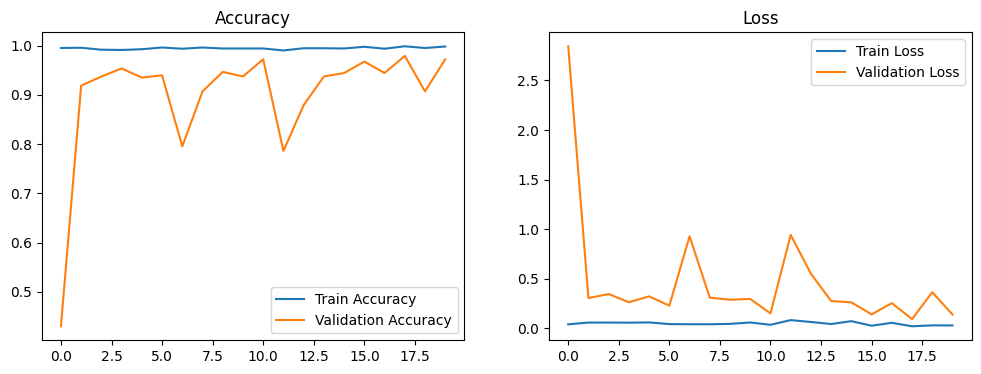

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()

## Dataset 3


In [9]:
path3 = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print("Path to dataset files:", path3)

Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [10]:
print("Dataset files and folders:")
print(os.listdir(path3))

Dataset files and folders:
['meningioma', 'organized_data', 'pituitary', 'glioma', 'healthy']


In [11]:
organized_path3 = organize_dataset(path3)

Class labels found: ['meningioma', 'pituitary', 'glioma', 'healthy']
Dataset organized into train, val, and test directories.


Found 4914 files belonging to 4 classes.
Found 1054 files belonging to 4 classes.
Found 1055 files belonging to 4 classes.


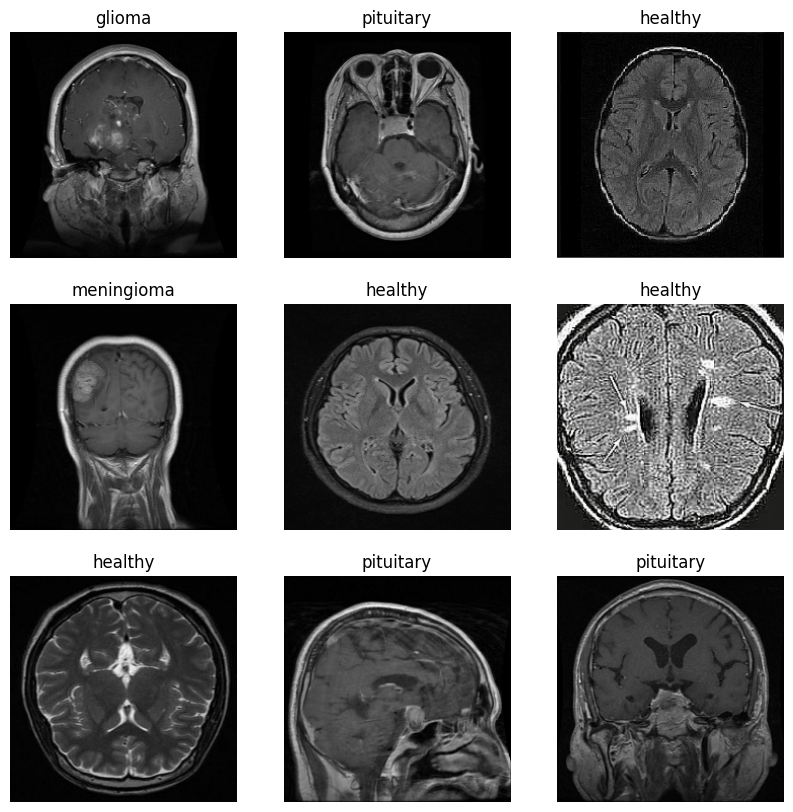

In [12]:
train_ds, val_ds, test_ds = load_datasets(organized_path3)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.show()

In [13]:
train_ds = prepare_datasets(train_ds)
val_ds = prepare_datasets(val_ds)
test_ds = prepare_datasets(test_ds)

In [14]:
Data3_model = build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,567 (16.08 MB)

 Trainable params: 4,172,288 (15.92 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [15]:
Data3_model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = Data3_model.fit( train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9790 - loss: 0.1715 - val_accuracy: 0.3387 - val_loss: 2.3238
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9832 - loss: 0.1146 - val_accuracy: 0.8776 - val_loss: 0.3605
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9851 - loss: 0.0867 - val_accuracy: 0.6584 - val_loss: 1.2285
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9807 - loss: 0.0937 - val_accuracy: 0.8937 - val_loss: 0.3990
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9869 - loss: 0.0891 - val_accuracy: 0.9279 - val_loss: 0.2274
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9905 - loss: 0.0656 - val_accuracy: 0.9459 - val_loss: 0.2569
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9833 - loss: 0.0854 - val_accuracy: 0.6139 - val_loss: 2.2552
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9881 - loss: 0

In [22]:
test_loss, test_accuracy = Data3_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9612 - loss: 0.1546
Test Accuracy: 95.55%


In [23]:
metrics_dataset3 = evaluate_metrics(test_ds, Data3_model)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Class 0:
  Precision: 0.9167
  Recall: 0.9918
  F1 Score: 0.9528
--------------------
Class 1:
  Precision: 0.9868
  Recall: 1.0000
  F1 Score: 0.9934
--------------------
Class 2:
  Precision: 0.9903
  Recall: 0.8259
  F1 Score: 0.9007
--------------------
Class 3:
  Precision: 0.9324
  Recall: 0.9924
  F1 Score: 0.9615
--------------------
averaged Precision: 0.9565
averaged Recall: 0.9525
averaged F1 Score: 0.9521


In [24]:
cm_dataset3 = evaluate_confusion_matrix(test_ds, Data3_model)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Confusion Matrix:
[[242   0   1   1]
 [  0 300   0   0]
 [ 21   4 204  18]
 [  1   0   1 262]]


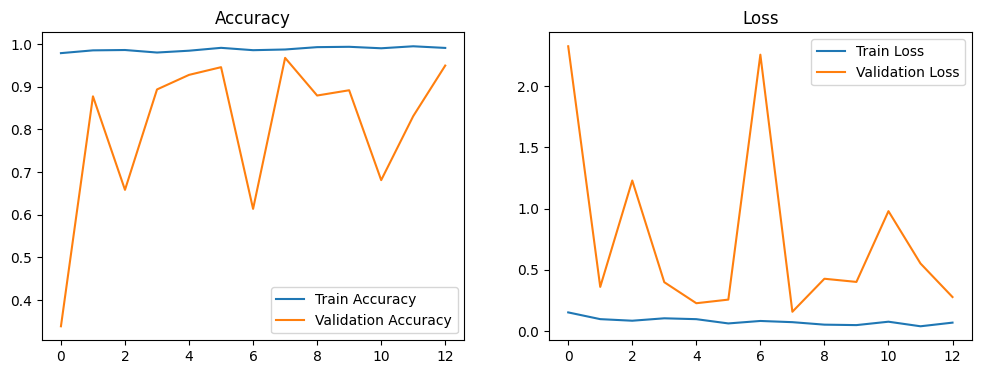

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()
